# Emotion GPT

This is a three stage procedure.

1. From a random subset (n=250) get a prediction about the emotion.

2. Create a set of this emotions.

3. Label the rest of the data accoring to these emotions.


__Update__

The three stafe procedure above turned out to not work well. Reasons, I suppose:

1. Slight change in the prompt causes GPT to classify differently. Change from identifyemotion in a text to select the most appropriate emotion from this set. Here the problem of 26 anger in the sample and 10 anger in the final data appeared.

Hence, I decdided to follow a two step procedure. First, aks for the emotion of each text, without pre-defining a label. Then pick the emotions wiht the most support, ie the emotions that occur at least x, times. I chose the number 20 given the rule of thumb of data support. These are the key emotions.

Second, I assign each sub-emotion, i.e. the emotions occuring less than 20 times to one of the key emotions. I do this by retrieving word embeddings from an embedding model, then match each sub-emotion to the closest key emotion in terms of cosine distance of their embeddings.


In [ ]:
%%capture
# Load basics
# Basics
!pip install openai
!pip uninstall umap
!pip install umap-learn
!pip install demoji

import demoji
import pandas as pd
import numpy as np
import openai
import matplotlib.pyplot as plt
import time
import pickle
import re
from collections import Counter
import umap.umap_ as umap

import gensim
import gensim.downloader
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# Load colab packages
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Inter/df_zelen_topics.csv')

In [ ]:
df.shape

(2351, 25)

In [ ]:
df[df.columns[15:]].head()

,message_split_uk,message_lan,message_score,en_original,uk_trans,message_final,topic
0,NaN,uk,0.999996,0,1,"At the morning selector meeting, I listened to...",-1
1,NaN,uk,0.999998,0,1,I chaired the Stavka meeting. The main issues ...,1
2,NaN,uk,0.999999,0,1,I met with the President of the Japanese Inter...,11
3,Війна – це зло. \nВійна – це трагедія.\nВійна ...,NaN,NaN,1,0,\n\nWar is evil. \nWar is tragedy.\nWar is a t...,-1
4,NaN,uk,0.999999,0,1,The number one issue at today's Stavka is mari...,1


## GPT emotion detection set-up

It is similar to the translation code, but the prompt changes.

In [ ]:
# openai Key
openai.api_key = 'XXXX'

In [ ]:
# final = "Please analyze the political text message by Zelenskyy, the president of Ukraine, regarding the Ukraine-Russia war. Identify the primary emotion conveyed in the message, indicate your level of confidence in this identification, and determine the dominance of this emotion in the text. Please respond in the format ['emotion', 'confidence', 'dominance'], where 'emotion' is a noun that represents the emotion, 'confidence' is a decimal between 0 and 1 representing the certainty of the model in its identification, and 'dominance' is a decimal between 0 and 1 representing the intensity or prevalence of the emotion in the text. Do not add any other text. Text:\n\n"


In [ ]:
# This is the prompt I generated with GPT-4
user_content_4 = "As a state-of-the-art AI with sophisticated text understanding abilities, your task is to determine and label the most prominent emotion communicated in the following political message."


# # Old one for GPT-3.5
# user_content = "As an advanced AI model with specialized training in comprehending and analyzing human emotions from textual content, particularly in the context of political communication, your task is to carefully assess the predominant emotion conveyed in the given message and provide a precise identification of it."
# #second_role = "Respond with a single noun that best describes the emotion, do not add any other text. Identify the main emotion in the following text: " + text

# test_1 = "Please analyze the following text from a political leader informing their social media followers about an ongoing war in their country. Identify the primary emotion conveyed:"
# test_2 = "Please provide your response in the format '['emotion', 'confidence']' where emotion is a single noun and confidence is confidence of your identification as a float. Analyze the following text and determine the main emotion:\n\n"

In [ ]:
# Function to prompt GPT to get the emotion of a text
def gpt_detect_emotion(text):
  emotion = ''
  retry_count = 0  # Counter for retry attempts
  while retry_count < 3:
        try:
          response = openai.ChatCompletion.create(
                                                  model = "gpt-4", # 'gpt-3.5-turbo'
                                                  temperature=0.0,
                                                  messages=[
                                                           {"role": "system", "content": user_content_4},
                                                           {"role": "user", "content": "Please provide a succinct, single-word noun that accurately captures the dominant emotion in the text. Do not add any other text. Text:\n\n " + text}, #test_2 + text
                                                           #"Please provide a succinct, single-word noun that accurately captures the core emotion being expressed. Do not add any other text. Text:\n\n " + text
]
                                    )
          emotion = response["choices"][0]["message"]["content"]
          break
        except openai.error.APIError as e:
            print("APIError occurred:", e)
            retry_count += 1
            print("wait...")
            time.sleep(5)
        except openai.error.RateLimitError as e:
            print("RateLimitError occurred:", e)
            retry_count += 1
            print("wait...")
            time.sleep(5)
        except Exception as e:
            print("Another error occurred:", e)
            retry_count += 1
            print("wait...")
            time.sleep(5)
  if retry_count == 3:
      print("Maximum retry attempts reached for text:", text)

  return emotion


## Step 1: Predict the emotion from the entire corpus

Important: here I change the prompts

In [ ]:
# Get emotions from the data
final_emotions = []
for index, row in df.iterrows():
  print('Message', index + 1)
  # Print status
  if (index + 1) % 50 == 0:
    print('Status: ', Counter(final_emotions))

  final_emotions.append(gpt_detect_emotion(row['message_final']))
  print(final_emotions[-1])

Streaming output truncated to the last 5000 lines.
Message 172
Neutral
Message 173
RateLimitError occurred: Rate limit reached for 10KTPM-200RPM in organization org-BIsTsQuVHhihGaSt30rvCQmj on tokens per min. Limit: 10000 / min. Please try again in 6ms. Contact us through our help center at help.openai.com if you continue to have issues.
Retrying after a brief wait...
Determination
Message 174
Defiance
Message 175
Pride
Message 176
Gratitude
Message 177
RateLimitError occurred: Rate limit reached for 10KTPM-200RPM in organization org-BIsTsQuVHhihGaSt30rvCQmj on tokens per min. Limit: 10000 / min. Please try again in 6ms. Contact us through our help center at help.openai.com if you continue to have issues.
Retrying after a brief wait...
Determination
Message 178
Hope
Message 179
Defiance
Message 180
Defiance
Message 181
Determination
Message 182
RateLimitError occurred: Rate limit reached for 10KTPM-200RPM in organization org-BIsTsQuVHhihGaSt30rvCQmj on tokens per min. Limit: 10000 / mi

## Step 2: cleaning and embeddings

First, perform basic cleaning and compute summaries. Then perform the aggregation of emotions using embeddings.

In [ ]:
# change the suffix "_final"
# Save the final emotions list, as hit has to be cleaned first
# with open('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Final/Emotions/final_emotions_gpt_4_final.pkl', 'wb') as f:
#     pickle.dump(final_emotions, f)
with open('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Final/Emotions/final_emotions_gpt_4_final.pkl', 'rb') as f:
    final_emotions = pickle.load(f)

In [ ]:
print('Len of final emotions list', len(final_emotions))

# Clean by lowering predictions
final_emotions_lower = [e.lower() for e in final_emotions]

# Clean by replacing "hopefuleness" with "hope" (this is not part of the glove embeddings corpus)
final_emotions_lower = ['hope' if emotion == 'hopefulness' else emotion for emotion in final_emotions_lower]
final_emotions_lower = ['support' if emotion == 'supportiveness' else emotion for emotion in final_emotions_lower]

print('Number of unique final emotions: ', len(set(final_emotions_lower)))
print('Number of unique final emotions larger than 20: ', len(set([e for e in final_emotions_lower if final_emotions_lower.count(e) > 24])))
print('Unique final emotions larger than 20: ', set([e for e in final_emotions_lower if final_emotions_lower.count(e) > 24]))

Len of final emotions list 2351
Number of unique final emotions:  60
Number of unique final emotions larger than 20:  11
Unique final emotions larger than 20:  {'gratitude', 'determination', 'outrage', 'optimism', 'pride', 'defiance', 'hope', 'fear', 'concern', 'patriotism', 'neutral'}


In [ ]:
# Frequencies of common emotions
Counter([e for e in final_emotions_lower if final_emotions_lower.count(e) > 24])

Counter({'concern': 46,
         'determination': 678,
         'gratitude': 548,
         'neutral': 55,
         'pride': 362,
         'optimism': 30,
         'patriotism': 28,
         'defiance': 183,
         'hope': 37,
         'fear': 28,
         'outrage': 127})

### Embedding assignment

1. Embedding model: I used glove rather than Google news as the prior is trained on tweets which comes closer to the corpus than news. Argue and maybe show that both give almost the same results

In [ ]:
# Load word embedding model (takes time)
google_vectors = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/My Drive/Colab Notebooks/Dissertation/GoogleNews-vectors-negative300.bin',
                                                         binary=True)
glove_vectors = gensim.downloader.load('glove-twitter-200')
wiki_vectors = gensim.downloader.load('fasttext-wiki-news-subwords-300')

[==================================================] 100.0% 758.5/758.5MB downloaded
[==================================================] 100.0% 958.5/958.4MB downloaded


In [ ]:
# Collect them
emb_models = [google_vectors, glove_vectors, wiki_vectors]

In [ ]:
# Alternative: using ada
# def get_embedding(text, model="text-embedding-ada-002"):
#    text = text.replace("\n", " ")
#    return openai.Embedding.create(input = [text], model=model)['data'][0]['embedding']

In [ ]:
# Create sets of core and sub emotions
print('Total unique emotions: ', len(set(final_emotions_lower)))
core_emotions = set([e for e in final_emotions_lower if final_emotions_lower.count(e) > 24])
sub_emotions = set([e for e in final_emotions_lower if final_emotions_lower.count(e) < 25])

print('Num key: ', len(core_emotions))
print('Num sub: ', len(sub_emotions))

Total unique emotions:  60
Num key:  11
Num sub:  49


In [ ]:
# Test whether comparing cosine similarity is the same as similarity() function
print(wiki_vectors.similarity('trust', 'fear'))
print(wiki_vectors.similarity('trust', 'optimism'))
#print(cosine_similarity([glove_vectors['anger']], [glove_vectors['hate']]) )

0.5479956
0.4285224


In [ ]:
# Use three models to get majority vote
from collections import Counter, defaultdict

# Store sub_emotions in a dict, collect closest score from each model
assignments = {sub_emotion: [] for sub_emotion in sub_emotions}

for model in emb_models:
    for sub_emotion in sub_emotions:
        core_sub_similarities = {core_emotion: model.similarity(sub_emotion, core_emotion) for core_emotion in core_emotions}
        closest_core_emotion = max(core_sub_similarities, key=core_sub_similarities.get)
        assignments[sub_emotion].append(closest_core_emotion)

In [ ]:
# Get the majority assignment
#majority_assignment = {sub: Counter(core).most_common(1)[0][0] for sub, core in assignments.items()}

majority_assignment = {}
for sub, core in assignments.items():
    common = Counter(core).most_common()
    if len(common) ==3:
        while True:
            user_input = input(f"There is a tie between {common[0][0]}, {common[1][0]} and {common[2][0]} for {sub}. Please choose one: ")
            if user_input in core_emotions:
                majority_assignment[sub] = user_input
                break
            else:
                print(f"{user_input} is not a valid core emotion. Please try again.")
    else:
      majority_assignment[sub] = common[0][0]

# Reverse assignment to: core: [list of subs with counts]
core_sub_final = {}
for sub, vote in majority_assignment.items():
  core_sub_final.setdefault(vote, []).append((sub, final_emotions_lower.count(sub)))

core_sub_final = {core: sorted(sub_counts, key=lambda x: x[1], reverse=True) for core, sub_counts in core_sub_final.items()}
core_sub_agg_df =pd.DataFrame(list(core_sub_final.items()), columns=['Dominant Emotions', 'Sub-Emotions and Counts'])

# Sorting
core_sub_agg_df['List Length'] = core_sub_agg_df['Sub-Emotions and Counts'].apply(len)
core_sub_agg_df = core_sub_agg_df.sort_values('List Length', ascending=False)
core_sub_agg_df = core_sub_agg_df.drop('List Length', axis=1).reset_index(drop=True)

# Create final list
final_emotions = [majority_assignment.get(emo, emo) for emo in final_emotions_lower]

There is a tie between pride, hope and optimism for inspiration. Please choose one: optimism
There is a tie between gratitude, fear and outrage for sorrow. Please choose one: fear
There is a tie between gratitude, concern and determination for cooperation. Please choose one: gratitude
There is a tie between pride, determination and gratitude for satisfaction. Please choose one: pride
There is a tie between gratitude, pride and patriotism for solidarity. Please choose one: gratitude
There is a tie between gratitude, fear and outrage for sadness. Please choose one: fear
There is a tie between determination, patriotism and optimism for calmness. Please choose one: optimism
There is a tie between patriotism, fear and optimism for nostalgia. Please choose one: patriotism
There is a tie between outrage, fear and pride for curiosity. Please choose one: pride
There is a tie between gratitude, hope and determination for support. Please choose one: gratitude
There is a tie between concern, hope 

In [ ]:
#core_sub_agg_df
#{sub: Counter(core).most_common() for sub, core in assignments.items()}
Counter(final_emotions)

Counter({'concern': 49,
         'determination': 681,
         'gratitude': 616,
         'neutral': 59,
         'pride': 367,
         'optimism': 83,
         'patriotism': 51,
         'outrage': 168,
         'defiance': 185,
         'hope': 44,
         'fear': 48})

In [ ]:
# Save the smoothed emotions list, as hit has to be cleaned first
# with open('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Final/smoothed_emotions_gpt_4_final.pkl', 'wb') as f:
#      pickle.dump(final_emotions, f)
with open('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Final/Emotions/smoothed_emotions_gpt_4_final.pkl', 'rb') as f:
    final_emotions_smoothed = pickle.load(f)

In [ ]:
Counter(final_emotions)

Counter({'concern': 49,
         'determination': 681,
         'gratitude': 616,
         'neutral': 59,
         'pride': 367,
         'optimism': 83,
         'patriotism': 51,
         'outrage': 168,
         'defiance': 185,
         'hope': 44,
         'fear': 48})

In [ ]:
def out_sub_to_core():

  with pd.option_context("max_colwidth", None):

    # Copy and rename columns
    df_out = core_sub_agg_df.copy()
    df_out['Sub-Emotions and Counts'] = df_out['Sub-Emotions and Counts'].apply(lambda x: ', '.join([str(i) for i in x]))
    df_out.columns = ['Dominant Emotion', 'Assigned Rare Emotions and Counts'] # 'Assigned Rare Emotions and Counts'

    # Add counts
    df_counts = pd.DataFrame.from_dict(Counter(final_emotions), orient='index').reset_index()
    df_counts.columns = ['Dominant Emotion', 'Final Count']
    merged_df = pd.merge(df_out, df_counts, on='Dominant Emotion', how='left')

    # DF of count change after semantic smoothing
    df_emo_before_after = pd.concat([pd.DataFrame.from_dict(Counter([e for e in final_emotions_lower if final_emotions_lower.count(e) > 19]), orient='index', columns=['Emotions before Clustering']),
                                pd.DataFrame.from_dict(Counter(final_emotions), orient='index', columns=['Emotions after Clustering'])], axis=1)

    df_emo_before_after['Dominant Emotion'] = df_emo_before_after.index
    df_emo_before_after = df_emo_before_after.sort_values('Emotions before Clustering', ascending=False)
    df_emo_before_after.loc['Total'] = [df_emo_before_after['Emotions before Clustering'].sum(),
                                        df_emo_before_after['Emotions after Clustering'].sum(),
                                        'Total']
    df_emo_before_after['Pre- to post percentage change'] = round((df_emo_before_after['Emotions after Clustering'] - df_emo_before_after['Emotions before Clustering']) / df_emo_before_after['Emotions before Clustering'] * 100,2)
    df_emo_before_after = df_emo_before_after[['Dominant Emotion', 'Emotions before Clustering',	'Emotions after Clustering',	'Pre- to post percentage change']]

    # Get just change column
    df_change = df_emo_before_after[['Dominant Emotion', 'Pre- to post percentage change']]
    df_change.columns = ['Dominant Emotion', '\\% change Semantic Smoothing'] #'Percentage change Semantic Smoothing'\\parbox[t]{2cm}{\% change \\ \\Semantic Smoothing}
    # \\parbox[t]{5cm}{Per change \\\\ Semantic Smoothing}

    # Merge all df and get tex
    merged_df = pd.merge(df_out, df_counts, on='Dominant Emotion', how='left')
    merged_df = pd.merge(merged_df, df_change, on='Dominant Emotion', how='left')
    merged_df.columns = ["Dominant Emotion"] + list(merged_df.columns[1:])

    # Change order
    merged_df = merged_df[['Dominant Emotion', 'Final Count', 'Assigned Rare Emotions and Counts', '\\% change Semantic Smoothing']]

    core_sub_agg_tex = merged_df.to_latex(index=False, escape=False)

  # Change tabular to tabularx and adjust column formats
  core_sub_agg_tex = core_sub_agg_tex.replace('\\begin{tabular}', '\\begin{tabularx}{\\textwidth}')
  core_sub_agg_tex = core_sub_agg_tex.replace('{lrlr}', '{lcXc}')
  core_sub_agg_tex = core_sub_agg_tex.replace('\\toprule\n', '\\toprule\\toprule\n')
  core_sub_agg_tex = core_sub_agg_tex.replace('\\end{tabular}', '\\end{tabularx}')
  core_sub_agg_tex = core_sub_agg_tex.replace("\\\n", "\\ \midrule\n")
  core_sub_agg_tex = core_sub_agg_tex.replace("\\\n", "\\ \midrule\n")
  #core_sub_agg_tex = core_sub_agg_tex.replace("Dominant Emotion &  Final Count &                                                                                                                                                                                                               Assigned Rare Emotions and Counts &  \\% change Semantic Smoothing \\\\ \\midrule", "Dominant &                                                                                                                                                                    Final &  Assigned Rare &  \\% change Semantic \\\\ \n Emotion &                                                                                                                                                                    Count &  Emotions and Counts & Smoothing \\\\")
  core_sub_agg_tex = core_sub_agg_tex.replace("Dominant Emotion &  Final Count &                                                                                                                                                                                          Assigned Rare Emotions and Counts &  \\% change Semantic Smoothing \\\\ \\midrule", "Common &                                                                                                                                                                    Final &  Assigned Rare &  \\% change Semantic \\\\ \n Emotion &                                                                                                                                                                    Count &  Emotions and Counts & Smoothing \\\\")
  core_sub_agg_tex = core_sub_agg_tex.replace('\\bottomrule\n', 'Total & 2085 & 266 &\\\\ \\midrule\n\\bottomrule\n')
  # core_sub_agg_tex = core_sub_agg_tex.replace("Dominant Emotion &                                                                                                                                                                    Assigned Rare Emotions and Counts &  Final Count &  \\% change Semantic Smoothing \\\\ \\midrule", " ")
  # core_sub_agg_tex = core_sub_agg_tex.replace("Dominant Emotion &  Final Count &                                                                                                                                                                                          Assigned Rare Emotions and Counts &  \\% change Semantic Smoothing \\\\ \\midrule", "")


  print(core_sub_agg_tex)
  with open('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Tables/emotion_main.tex', 'w') as file:
      file.write(core_sub_agg_tex)

out_sub_to_core()

\begin{tabularx}{\textwidth}{lcXc}
\toprule\toprule
Common &                                                                                                                                                                    Final &  Assigned Rare &  \% change Semantic \\ 
 Emotion &                                                                                                                                                                    Count &  Emotions and Counts & Smoothing \\
\midrule
       gratitude &          616 & ('solidarity', 16), ('respect', 11), ('support', 8), ('relief', 7), ('appreciation', 6), ('welcoming', 4), ('cooperation', 4), ('admiration', 4), ('sympathy', 3), ('encouragement', 3), ('caring', 1), ('remembrance', 1) &                         12.41 \\ \midrule
         outrage &          168 &                                                                               ('anger', 21), ('indignation', 11), ('accusation', 2), ('contempt', 2), ('frustration', 2),

<ipython-input-152-26960f6350e4>:40: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  core_sub_agg_tex = merged_df.to_latex(index=False, escape=False)


__Example messages per emotion__

In [ ]:
def emotion_examples(df=df):

    # Get copy and filter df
    with pd.option_context("max_colwidth", None):
      df_emo = df.copy()
      df_emo = df_emo[df_emo['message_final'].str.len().between(10, 500)]
      df_emo = df_emo[['emotion_gpt','message_final']]

      def concat_texts(group):
        selected_texts = group.sample(n=2, random_state=11)['message_final']
        selected_texts = ['\"' + t + '\"' for t in selected_texts]
        return '\\newline \\newline '.join(selected_texts)


      samples = pd.DataFrame(df_emo.groupby('emotion_gpt').apply(concat_texts), columns=['Examples'])
      samples['Emotion'] = samples.index
      samples = samples[['Emotion', 'Examples']].reset_index(drop=True)
      # group df
      # samples = df_emo.groupby('emotion_gpt').apply(lambda group: group.sample(n=3, random_state=1)).reset_index(drop=True)

      latex_table = samples.to_latex(index=False, escape=False)
      latex_table = latex_table.replace('\\begin{tabular}{ll}', '\\begin{tabular}{lp{12cm}}')
      latex_table = latex_table.replace('\\toprule', '\\toprule\\toprule')
      latex_table = latex_table.replace('\\midrule', '')
      latex_table = latex_table.replace(' \\\\', ' \\\\ \\midrule')
      #latex_table = latex_table.replace('\\bottomrule', '\\bottomrule\\bottomrule')
    print(latex_table)
    # Write the LaTeX code to a file
    with open('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Tables/emotion_examples.tex', 'w') as file:
      file.write(latex_table)

In [ ]:
emotion_examples(df)

\begin{tabular}{lp{12cm}}
\toprule\toprule
      Emotion &                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                Examples \\ \m

<ipython-input-10-abf227943572>:21: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = samples.to_latex(index=False, escape=False)


In [ ]:
# Consistency checks
print('Len of aggregated emotions list ', len(final_emotions))
print('Number of unique emotions in aggregated list', len(set(final_emotions)))

Len of aggregated emotions list  2351
Number of unique emotions in aggregated list 11


### Visualisations

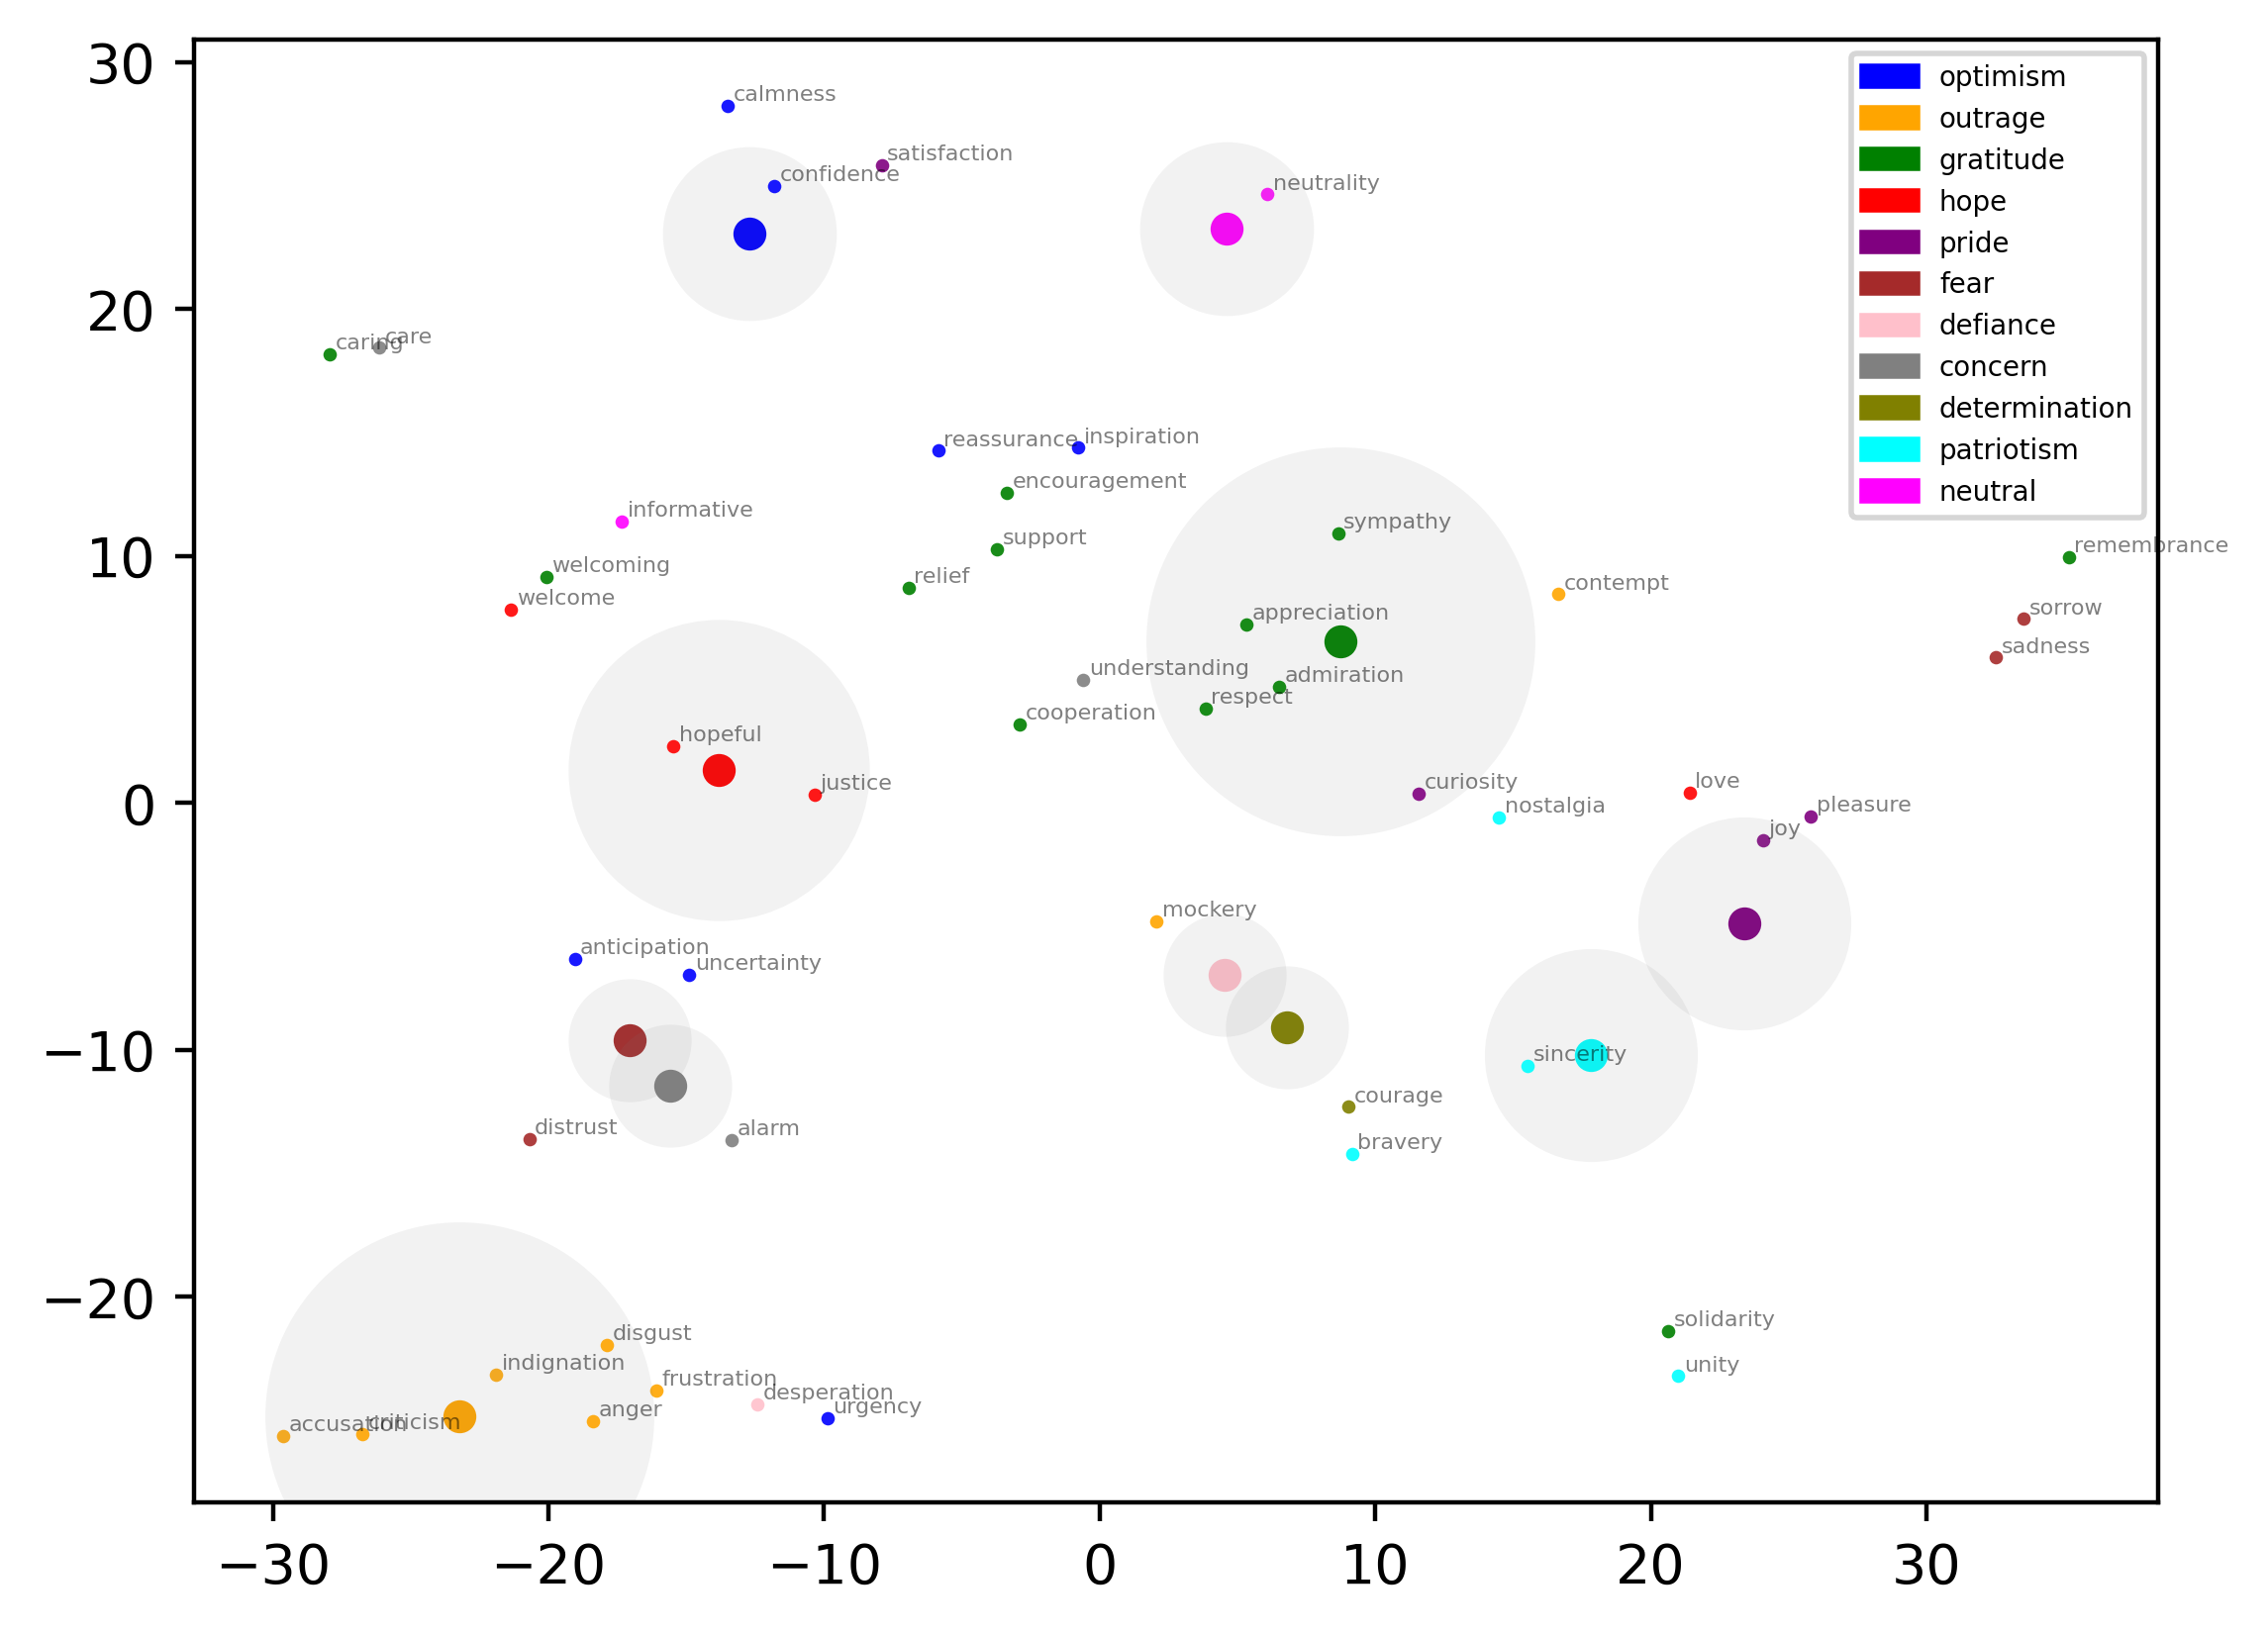

In [ ]:
from sklearn.manifold import TSNE
from matplotlib.patches import Patch
def plot_emotions():

  # get embedings
  core_emotion_vectors = {emotion: google_vectors[emotion] for emotion in core_emotions}
  all_emotions = set(final_emotions_lower)
  all_vectors = np.array([google_vectors[emotion] for emotion in all_emotions])

  # use t sne instead of UMAP
  tsne_embeddings = TSNE(n_components = 2,
                         random_state = 16,
                         perplexity=4).fit_transform(all_vectors) # best 5

  # all colors
  colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta']
  color_map = {core_emotion: colors[i] for i, core_emotion in enumerate(core_emotion_vectors.keys())}

  size_map = {'optimism': 1000, 'outrage': 5000, 'gratitude': 5000, 'hope': 3000,
              'pride': 1500, 'fear': 500, 'defiance': 500, 'concern': 500,
              'determination': 500, 'patriotism': 1500, 'neutral': 1000}


  # Create a scatter plot
  plt.figure(dpi=400)

  for i, emotion in enumerate(all_emotions):
      x, y = tsne_embeddings[i, :]
      size = size_map[emotion] if emotion in size_map else 20

      if emotion not in core_emotions:  # If it's a sub-emotion, use the color of the corresponding key emotion
          plt.scatter(x, y, color=color_map[majority_assignment[emotion]], alpha=0.9, linewidths=0, s=6)
          plt.text(x+0.2, y+0.2, emotion, size=4, alpha=.5)
      else:  # core emotion
          plt.scatter(x, y, color=color_map[emotion], linewidths=0)
          plt.scatter(x, y, color='grey', alpha=0.1, s=size, linewidths=0)
          # plt.text(x+0.7, y+0.7, emotion, size=8, alpha=1, weight='bold')


  legend_elements = [Patch(facecolor=color_map[emotion], edgecolor=color_map[emotion],
                         label=emotion) for emotion in color_map.keys()]

  #
  plt.legend(handles=legend_elements, loc='upper right', fontsize=5)

  plt.savefig('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Images/emotions.png',
              dpi=300)
  plt.show()

plot_emotions()


## OUT

In [ ]:
# Save df
df['emotion_gpt'] = final_emotions_smoothed # final_emotions; depending on what var is used
df['emotion_gpt_before_ss'] =  final_emotions
#df.to_csv('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Inter/df_zelen_emotions_gpt.csv')
#df = pd.read_csv('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Inter/df_zelen_emotions_gpt.csv')

# Validation

This is to validate the approach methodological approach suggested.

## Pilot

This test the MTurk design on a random subset of 20 emotions.

In [ ]:
df.columns

Index(['Unnamed: 0', 'id', 'date', 'message', 'views', 'forwards', 'reactions',
       'mime_type', '😢', '🙏', '❤', '👍', 'Total_emoijs', 'message_both',
       'message_split_en', 'message_split_uk', 'message_lan', 'message_score',
       'en_original', 'uk_trans', 'message_final', 'topic',
       'topic_no_outliers', 'emotion_gpt'],
      dtype='object')

In [ ]:
# New including BERT
def df_validation_sampling(n, df=df):

  df_original = df.copy()
  # Get messages of min size (e.g. no "Glory to Ukraine")
  df_original = df_original[df_original['message_final'].str.len() >= 10]
  df_original = df_original[df_original['emotion_label_hart'] != 'surprise']

   # GPT
  num_per_emotion = (n // df_original['emotion_gpt'].nunique())
  print(num_per_emotion)
  #num_per_emotion = (n // df_original['emotion_gpt'].nunique())

  df_gpt = df_original[['message_final', 'emotion_gpt', 'emotion_gpt_before_ss']].groupby('emotion_gpt').apply(lambda x: x.sample(num_per_emotion if len(x) >= num_per_emotion else len(x), random_state=42)).reset_index(drop=True, level=0)
  df_gpt.columns = ['text_gpt', 'suggested_emotion_gpt', 'emotion_gpt_before_ss']

  # Ensure no overlapping
  df_remaining = df_original.copy()
  df_remaining = df_remaining.drop(df_gpt.index).reset_index()

  # BERT
  num_per_emotion = (n // df_remaining['emotion_label_hart'].nunique())
  print(num_per_emotion)

  df_bert = df_remaining[['message_final', 'emotion_label_hart']].groupby('emotion_label_hart').apply(lambda x: x.sample(num_per_emotion if len(x) >= num_per_emotion else len(x), random_state=42)).reset_index(drop=True, level=0)
  df_bert.index.name = df_remaining.index.name
  df_bert.columns = ['text_bert', 'suggested_emotion_bert']

  # Control
  control_text = [ "Despite the dark times we face, remember, we carry an unyielding flame of hope within us. Though the outcome is not entirely in our hands, we steadfastly hope for a brighter tomorrow."]
  df_control = pd.DataFrame({'text_test': control_text * n,
                             'suggested_emotion_test': ['neutral'] * n})

  # Remove emoijs
  df_bert['text_bert'] = df_bert['text_bert'].apply(lambda x: demoji.replace(x, ""))
  df_gpt['text_gpt'] = df_gpt['text_gpt'].apply(lambda x: demoji.replace(x, ""))
  df_control['text_test'] = df_control['text_test'].apply(lambda x: demoji.replace(x, ""))

  df_out = pd.concat([df_bert.reset_index(drop=True),
                      df_gpt.reset_index(drop=True),
                      df_control.reset_index(drop=True)], axis=1).dropna()
  return df_out

## Pilot

In [ ]:
# Get the pilot data
df_pilot = df_validation_sampling(40)
#dff_pilot = dff_pilot[:3]
df_pilot.to_csv('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Final/df_pilot_bert.csv', index=False)

In [ ]:
df_pilot

## Validation

In [ ]:
# df for the validation
df_validation = df_validation_sampling(275)
df_validation.shape
df_validation.to_csv('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Final/Validation/df_validation_fear_check.csv', index=False)

25
45


In [ ]:
# Brief consistency checks
print("GPT's distribution", np.unique(df_validation['suggested_emotion_gpt'], return_counts=True))
print("BERT's distribution",np.unique(df_validation['suggested_emotion_bert'], return_counts=True))

GPT's distribution (array(['concern', 'defiance', 'determination', 'fear', 'gratitude',
       'hope', 'neutral', 'optimism', 'outrage', 'patriotism', 'pride'],
      dtype=object), array([25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 20]))
BERT's distribution (array(['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness'],
      dtype=object), array([45, 45, 45, 45, 45, 45]))


In [ ]:
np.unique(df_validation['text_bert'], return_counts=True)[1]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In [ ]:
df_validation

,text_bert,suggested_emotion_bert,text_gpt,suggested_emotion_gpt,emotion_gpt_before_ss,text_test,suggested_emotion_test
0,"I appeal to all Ukrainians, wherever we are. D...",anger,\n\nI had a meeting with UN Secretary-General ...,concern,Concern,"Despite the dark times we face, remember, we c...",neutral
1,"By buying Russian oil and gas, you are financi...",anger,During the conference of analytical centers in...,concern,Concern,"Despite the dark times we face, remember, we c...",neutral
2,During the annual meeting of the Yalta Europea...,anger,"\n\nDue to the Russian invasion, all Ukrainian...",concern,Concern,"Despite the dark times we face, remember, we c...",neutral
3,"On this day, the 101st day of the full-scale w...",anger,We must jointly protect Ukraine and the entire...,concern,Concern,"Despite the dark times we face, remember, we c...",neutral
4,"Before the war, we used to calmly say at the e...",anger,\n\nThe civilized world is moving forward and ...,concern,Concern,"Despite the dark times we face, remember, we c...",neutral
...,...,...,...,...,...,...,...
265,"I wish you good health, dear Ukrainians!\n\nTo...",sadness,\n\nBeing a father is a great responsibility a...,pride,Pride,"Despite the dark times we face, remember, we c...",neutral
266,Today is a fruitful day for our state - fruitf...,sadness,"\n\nThe Ukrainian flag, although riddled with ...",pride,Pride,"Despite the dark times we face, remember, we c...",neutral
267,Speech by @FirstLadyOfUkraine in the US Congre...,sadness,A warm meeting with representatives of the you...,pride,Pride,"Despite the dark times we face, remember, we c...",neutral
268,\n\nLviv. Consequences of the night attack by ...,sadness,_\n\nThis is a special Mother's Day. Scorched ...,pride,Pride,"Despite the dark times we face, remember, we c...",neutral
